# MRI Image Orientation Classifier

Magnetic Resonance Imaging (MRI) is a medical imaging modality that uses magnetic fields and magnetic field gradients to generate images of the anatomy and/or physiology. MRI techniques that yield images of the anatomy are called *structural* imaging methods, whereas techniques that generate images of the physiological processes are called *functional* imaging. Often, a MRI dataset is 3-dimensional matrix and can be visualized in three anatomical planes:
* **Axial plane**: divides body into head and tail
* **Sagittal plane**: divides body into left and right
* **Coronal plane**: divides body in front and back

For the brain specifically, radiologists and technicians tend to prefer viewing in axial plane. However, any visualization software can convert a 3-dimensional dataset into any of the anatomical planes for viewing. Since knowing which anatomical orientation the dataset is in helps facilitate analysis, I am creating a convolutional neural network to classifier MRI slices (2-dimensional slices) into three categories: axial, sagittal and coronal.

The following dataset is a set of T2-weighted structural images acquired in healthy and anemic subjects. Even though all the data used have been anonymized and de-identified, I am still not allowed to share patient data on a public repository. Therefore, no patient dataset is uploaded in the data folder.

For illustration purposes, I have acquired one T2-weighted dataset on myself, can be downloaded [here](https://github.com/chauvu/chauvu.github.io/tree/main/Data/mri_t2). Note that the T2-weight image (`CV_T2.nii`) and the mask file (`CV_T2_bet_mask.nii.gz`) are in NIFTI format, which is a compressed format frequently used in medical imaging. We will use the specialized Python library `nibabel` to handle these NIFTI images. I will be demonstrating all the preprocessing steps on this single dataset before training the CNN on the full cohort.

In [1]:
import numpy as np
import scipy as sp
from scipy.ndimage import rotate, zoom
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn import model_selection
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint

np.random.seed(1)

Some variables set initially include `target_size`. Since each institution has a different protocol for T2-weighted imaging and likely generates different image sizes, all images need to be reshaped to a standard size. I have chosen to reshape to a **square** with size=`224` (which is the size compatible with VGG networks). 

Additionally, each dataset comes with a *mask* file. Since each brain MRI does not only contain regions within the brain, but also the skull and areas outside of the body (air). I have utilized a specialized MRI software to perform *brain extraction*, yielding a binary mask file with `0` as outside the brain and `1` as inside the brain. The variable `mask_threshold` is set to 0.15, denoting that a 2-dimensional slice is only considered if the area of the (mask) brain is at least 15% of the total area.

In [2]:
target_size = 224 # square
mask_threshold = 0.15 # 15% within brain mask, used for target_size
already_trained = 1

For each 3-dimensional dataset, we will be able to generate 3 subset, each of a different anatomical plane. For each anatomical plane, we can generate multiple (10-30) 2-dimensional slices of the T2-weighted data. In this pre-processing step, I will create 3 empty 224x224 numpy arrays:
* `im_axial`
* `im_sagittal`
* `im_coronal`

The 8000 number of expected slices is approximated for memory allocation. The actual number of slices is smaller and the array will be reshaped to that size. For each plane I also have a counter variable in order to keep track of the number of slices already processed.

In [3]:
im_axial = np.zeros((target_size, target_size, 8000))
im_sagittal = np.zeros((target_size, target_size, 8000))
im_coronal = np.zeros((target_size, target_size, 8000))

im_axial_counter = 0
im_sagittal_counter = 0
im_coronal_counter = 0

Now I will pre-process MRI data acquired on myself.

In [4]:
img = nib.load('../Data/mri_t2/CV_T2.nii')
t2_axial = img.get_fdata() # originally axial
img = nib.load('../Data/mri_t2/CV_T2_bet_mask.nii.gz')
mask_axial = img.get_fdata()

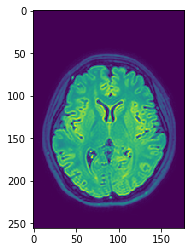

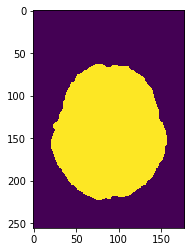

In [5]:
# axial view
# transpose and flipud are to visualize image better with pyplot
plt.imshow(np.flipud(np.transpose(t2_axial[:,:,175])))
plt.show()

# mask
plt.imshow(np.flipud(np.transpose(mask_axial[:,:,175])))
plt.show()

In [6]:
image_size = t2_axial.shape
image_size

(178, 256, 256)

So the size of this 3-dimensional dataset is 178 x 256 x 256. In order to make all 2D slices square, this 3D dataset needs to be reshaped to a cube, each side = `224`. To do this without too much disproportionate shrinking of one dimension compared to another, I will zero-pad all dimensions to attain a cube with side as the largest dimension (`pad_size`). In our case, the dataset will be padded to size 256 x 256 x 256. We see that the resulting axial slice shown below is now a square instead of a rectangle!

In [7]:
pad_size = np.max(image_size)
pad_size_dim = np.argmax(image_size)
t2_temp = np.zeros((pad_size, pad_size, pad_size))
mask_temp = np.zeros((pad_size, pad_size, pad_size))
pad_dims = np.zeros((3,2))
for dim in range(3): # 3 dimensions
    if pad_size == image_size[dim]:
        pad_dims[dim, 0] = 0
        pad_dims[dim, 1] = pad_size
    else: # smaller than pad_size
        pad_dims[dim, 0] = int((pad_size - image_size[dim]) / 2)
        pad_dims[dim, 1] = pad_size - int((pad_size - image_size[dim]) / 2)
pad_dims = pad_dims.astype(int)
t2_temp[pad_dims[0,0]:pad_dims[0,1], pad_dims[1,0]:pad_dims[1,1], pad_dims[2,0]:pad_dims[2,1]] = t2_axial
mask_temp[pad_dims[0,0]:pad_dims[0,1], pad_dims[1,0]:pad_dims[1,1], pad_dims[2,0]:pad_dims[2,1]] = mask_axial
t2_axial = t2_temp
mask_axial = mask_temp
image_size = t2_axial.shape
image_dim = image_size[0] # all dimensions should be the same now

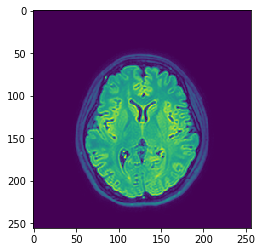

In [8]:
plt.imshow(np.flipud(np.transpose(t2_axial[:,:,175])))
plt.show()

Afterward, `t2_axial` is now used to convert to `t2_sagittal` and `t2_coronal` through simple dimensional permutation.

In [9]:
t2_sagittal = np.flipud(np.transpose(t2_axial, [2,1,0]))
mask_sagittal = np.flipud(np.transpose(mask_axial, [2,1,0]))

t2_coronal = np.flipud(np.transpose(t2_axial, [2,0,1]))
mask_coronal = np.flipud(np.transpose(mask_axial, [2,0,1]))

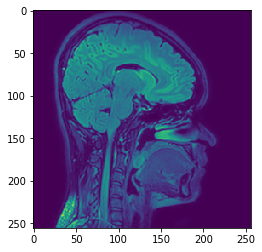

In [10]:
# sagittal
plt.imshow(t2_sagittal[:,:,120])

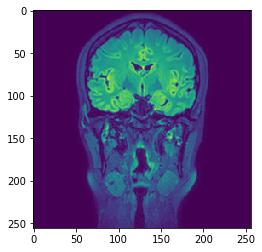

In [11]:
# coronal
plt.imshow(t2_coronal[:,:,120])

Since all MRI images end up looking quite similar structurally (axial and coronal images are symmetrical left-right, sagittal images have brain stem running vertically), if a CNN is trained on these very well-placed planes, the results are not robust to changes in subject orientations. For example, if a subject is placed in the MRI at an angle, or for some reason the images are rotated < 90 degrees (some MRI softwares de-oblique images to conform to the universal MRI template and could potentially cause rotations).

Therefore, instead of training on these clean T2-weighted images, I will perform some data augmentation using function `zoom_crop_rotate`:
* **Zoom**: zoom in or zoom out, from 80% to 120% of original `target_size`
* **Crop**: crop based on zoom range, check brain coverage > `mask_threshold`
* **Rotate**: rotate any degrees between 0 and 360 degrees

In [12]:
def zoom_crop_rotate(t2_axial_slice, mask_axial_slice):
    # random zoom
    zoom_rand_var = (np.random.rand() * 2 - 1) * 0.2 * target_size # zoom vary 20% of target_size
    zoom_rand_size = int(np.round(target_size + zoom_rand_var))
    if zoom_rand_size > image_dim:
        zoom_rand_size = image_dim
    # random crop
    flag = 0
    while flag == 0:
        x_rand = int(np.floor(np.random.rand() * (image_dim - zoom_rand_size))) # top left x
        y_rand = int(np.floor(np.random.rand() * (image_dim - zoom_rand_size))) # top left y
        t2_cropped = t2_axial_slice[x_rand:x_rand+zoom_rand_size, y_rand:y_rand+zoom_rand_size]
        mask_cropped = mask_axial_slice[x_rand:x_rand+zoom_rand_size, y_rand:y_rand+zoom_rand_size]
        if mask_cropped.sum() / zoom_rand_size**2 > mask_threshold * (target_size**2) / (zoom_rand_size**2):
            flag = 1
            break
    # random rotate
    angle_rand = np.random.rand() * 360 # 360 degrees
    t2_rotated = rotate(t2_cropped, angle_rand, reshape=False)
    # reshape to target_size
    t2_reshape = zoom(t2_rotated, [target_size/zoom_rand_size, target_size/zoom_rand_size])
    t2_reshape = (t2_reshape - t2_reshape.min()) / (t2_reshape.max() - t2_reshape.min()) * 255 # store as int
    return t2_reshape

In [13]:
# perform data augmentation with cropping and rotation
for z in range(image_dim): # loop through slices
    t2_axial_slice = t2_axial[:,:,z]
    mask_axial_slice = mask_axial[:,:,z]
    t2_sagittal_slice = t2_sagittal[:,:,z]
    mask_sagittal_slice = mask_sagittal[:,:,z]
    t2_coronal_slice = t2_coronal[:,:,z]
    mask_coronal_slice = mask_coronal[:,:,z]

    ## axial
    if mask_axial_slice.sum() / image_dim**2 > mask_threshold * (target_size**2) / (image_dim**2): # scaled threshold
        t2_reshape = zoom_crop_rotate(t2_axial_slice, mask_axial_slice)
        im_axial[:,:,im_axial_counter] = t2_reshape
        im_axial_counter += 1
        
    ## sagittal
    if mask_sagittal_slice.sum() / image_dim**2 > mask_threshold * (target_size**2) / (image_dim**2): # scaled threshold
        t2_reshape = zoom_crop_rotate(t2_sagittal_slice, mask_sagittal_slice)
        im_sagittal[:,:,im_sagittal_counter] = t2_reshape
        im_sagittal_counter += 1
        
    ## coronal
    if mask_coronal_slice.sum() / image_dim**2 > mask_threshold * (target_size**2) / (image_dim**2): # scaled threshold
        t2_reshape = zoom_crop_rotate(t2_coronal_slice, mask_coronal_slice)
        im_coronal[:,:,im_coronal_counter] = t2_reshape
        im_coronal_counter += 1
        
im_axial = im_axial[:,:,:im_axial_counter]
im_sagittal = im_sagittal[:,:,:im_sagittal_counter]
im_coronal = im_coronal[:,:,:im_coronal_counter]

After applying data augmentation, I finally have the three numpy arrays `im_axial`, `im_sagittal` and `im_coronal`. There are 101 axial slices, 100 sagittal slices and 106 coronal slices. This shows that the three categories will be fairly balanced, which is good news for our classification. Example augmented images of each orientation are also shown in the cells below.

In [14]:
print('Axial array shape: {}', im_axial.shape)
print('Sagittal array shape: {}', im_sagittal.shape)
print('Coronal array shape: {}', im_coronal.shape)

Axial array shape: {} (224, 224, 101)
Sagittal array shape: {} (224, 224, 100)
Coronal array shape: {} (224, 224, 106)


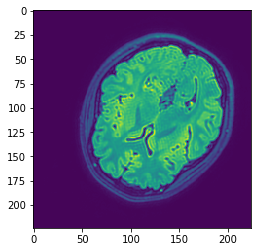

In [15]:
# axial
plt.imshow(im_axial[:,:,50])

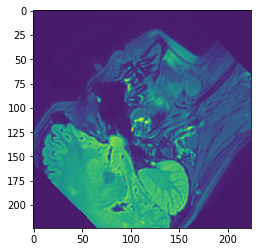

In [16]:
# sagittal
plt.imshow(im_sagittal[:,:,70])

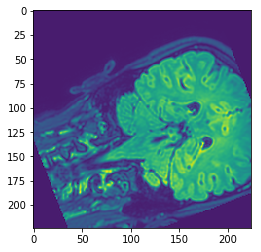

In [17]:
# coronal
plt.imshow(im_coronal[:,:,40])

Since I have illustrated the processing and data augmentation performed on the T2-weighted MRI dataset acquired on myself, I will now load in the large dataset including 60 subjects. This data will not be made available on the Data folder.

In [18]:
with open('/Users/chauvu/Documents/Chau/DataScience/Proj_SCI_CNN/im_t2_axial_format.npy','rb') as f: 
    im_axial = np.load(f) 
with open('/Users/chauvu/Documents/Chau/DataScience/Proj_SCI_CNN/im_t2_sagittal_format.npy','rb') as f: 
    im_sagittal = np.load(f) 
with open('/Users/chauvu/Documents/Chau/DataScience/Proj_SCI_CNN/im_t2_coronal_format.npy','rb') as f: 
    im_coronal = np.load(f) 

In [19]:
im_axial_shape = im_axial.shape
im_sagittal_shape = im_sagittal.shape
im_coronal_shape = im_coronal.shape
n_data = im_axial_shape[0] + im_sagittal_shape[0] + im_coronal_shape[0]
print('Number of 2D slices: ', n_data)
input_shape = (target_size, target_size, 1)

# scale, shuffle and divide into training and testing set
im_axial /= 255
im_sagittal /= 255
im_coronal /= 255

Number of 2D slices:  22089


These three sets of images are concatenated and shuffled. The total number of 2-dimensional MRI images is **22089**. The data is split into 80% training and 20% testing. Arbitrarily, the labels for each category are as follows: 
* Axial = 0
* Sagittal = 1
* Coronal = 2

In [20]:
data = np.concatenate((im_axial, im_sagittal, im_coronal), axis=0)
# labels: axial = 0, sagittal = 1, coronal = 2
labels = np.concatenate((np.ones((im_axial_shape[0],))*0, np.ones((im_sagittal_shape[0],))*1, np.ones((im_coronal_shape[0],))*2))
shuffle_order = np.int16(np.linspace(0,n_data-1,n_data))
np.random.shuffle(shuffle_order)
data_shuffled = data[shuffle_order]
labels_shuffled = labels[shuffle_order]

data_train, data_test, labels_train, labels_test = model_selection.train_test_split(data_shuffled, labels_shuffled, test_size=0.2, random_state=0)

Let's start with a simple convolutional neural network with only 1 convolution layer. We will train this for 20 epochs. After training, this network achieves a **90%** accuracy in the test set.

In [21]:
def cnn1_model(dropout_rate=0.20, kernel_size=(3,3), optimizer='adam',
                dense_params=256, maxpool_size=(2,2), activation='relu', numclass=3):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
model = cnn1_model()
filepath="../Data/mri_t2/T2orientation-cnn1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
if already_trained == 0:
    model.fit(x=data_train, y=labels_train, epochs=20, batch_size=128, callbacks=callbacks_list)
else:
    model.load_weights('../Data/mri_t2/T2orientation-cnn1.hdf5')
    model.evaluate(data_test, labels_test)

139/139 [==============================] - 42s 305ms/step - loss: 0.4457 - accuracy: 0.8959


Now we will train a CNN with 3 convolution layers for 20 epochs. This network achieves **98%** accuracy in the test set.

In [26]:
def cnn3_model(dropout_rate=0.20, kernel_size=(3,3), optimizer='adam',
                dense_params=128, maxpool_size=(2,2), activation='relu', numclass=3):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=kernel_size, activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=maxpool_size))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=maxpool_size))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=maxpool_size))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(dense_params, activation=activation, kernel_initializer='random_normal'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(numclass, activation='softmax', kernel_initializer='random_normal'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
model = cnn3_model()
filepath="../Data/mri_t2/T2orientation-cnn3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
if already_trained == 0:
    model.fit(x=data_train, y=labels_train, epochs=20, batch_size=128, callbacks=callbacks_list)
else:
    model.load_weights('../Data/mri_t2/T2orientation-cnn3.hdf5')
    model.evaluate(data_test, labels_test)

139/139 [==============================] - 79s 571ms/step - loss: 0.0784 - accuracy: 0.9778


I evaluating which categories our network is getting correctly and incorrectly, I will look at the true positive and false positive rates for each orientation. As proven above, our data is fairly well balanced, and we see that the true and false positive rates are also quite comparable between the different labels.

In [28]:
test_preds = model.predict(data_test).argmax(axis=1) # predictions
tpr0 = ((test_preds==0) & (labels_test==0)).sum() / (labels_test==0).sum()
fpr0 = ((test_preds==0) & (labels_test!=0)).sum() / (labels_test!=0).sum()
tpr1 = ((test_preds==1) & (labels_test==1)).sum() / (labels_test==1).sum()
fpr1 = ((test_preds==1) & (labels_test!=1)).sum() / (labels_test!=1).sum()
tpr2 = ((test_preds==2) & (labels_test==2)).sum() / (labels_test==2).sum()
fpr2 = ((test_preds==2) & (labels_test!=2)).sum() / (labels_test!=2).sum()
print(np.round([tpr0, fpr0, tpr1, fpr1, tpr2, fpr2],2))

[0.97 0.01 0.98 0.01 0.98 0.02]


We can also try to visualize some layers. Likely, the first layers will make sense (whether the network is focusing on a particular edge, feature or landmark). The later layers will likely look more abstract, so let us only examine the result of the first convolution layer. I have created the function `plot_weights`, which takes in the CNN model, 2 images and layer number as input; `filter_number` refers to the specific filter we wish to visualize. This function will use `im_show` to visualize the layers.

Below I show visualization for the 1st and 2nd test images in `layer_number=1`, `filter_number=0` and `filter_number=1`.

In [34]:
def plot_weights(model, im1, im2, layer_number=-3, target_size=224, kind='plot', filter_number=0):
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    img_tensor = np.reshape(im1, [1,target_size,target_size,1])
    activations1 = activation_model.predict(img_tensor)
    activations1_layer = activations1[layer_number]
    if kind=='plot':
        activations1_layer = np.reshape(activations1_layer, (-1,1))
        plt.plot(activations1_layer, 'r', label='1')
    elif kind=='imshow':
        plt.subplot(1,2,1)
        plt.imshow(activations1_layer[0,:,:,filter_number])

    img_tensor = np.reshape(im2, [1,target_size,target_size,1])
    activations2 = activation_model.predict(img_tensor)
    activations2_layer = activations2[layer_number]
    if kind=='plot':
        activations2_layer = np.reshape(activations2_layer, (-1,1))
        plt.plot(activations2_layer, 'b', label='2')
    elif kind=='imshow':
        plt.subplot(1,2,2)
        plt.imshow(activations2_layer[0,:,:,filter_number])
        
#     plt.show()
#     plt.legend(loc='upper right')
    return [activations1_layer, activations2_layer]

Here are the first and second images from the testing set. The 1st and 2nd filters are also shown below. It looks like both filters focus on the edges, with the first filter focusing on the right edge while the second one focusing on the bottom edge. Further evaluation of more filters is necessary, but at least partial evaluation shows that the 1st convolution layer is functioning as expected.

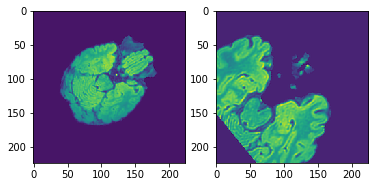

In [39]:
im1 = data_test[0,:,:,0] # first image
im2 = data_test[1,:,:,0] # second image
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

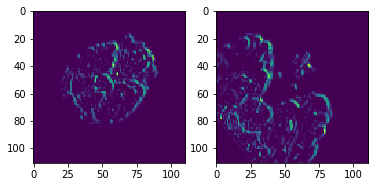

In [40]:
l1, l2 = plot_weights(model, im1, im2, layer_number=1, kind='imshow', filter_number=0)

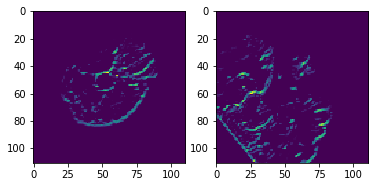

In [41]:
l1, l2 = plot_weights(model, im1, im2, layer_number=1, kind='imshow', filter_number=1)

# Final words
I have not performed a lot of parameter tuning and optimization in this project. Therefore, I did not include a separate validation set in addition to the training and testing sets. This is due to the lack of time and resources. I will likely come back to this project to optimize the CNN for classification. However, this work shown here is proof of concept, showing that it is possible to classify different anatomical orientations in MRI images even by using fairly simple convolutional neural networks trained for only 20 epochs.

Even without optimization and after only 20 epochs (learning rate 0.01), the simple 1-convolution-layer network achieves 90% accuracy while the 3-convolution-layer network achieves 98% accuracy. This high accuracy can be attributed to the quality of our dataset:
* This is a research dataset acquired at high resolution with all MRI parameters previously optimized.
* Structurally, the three anatomical planes are very different. With a balanced dataset and clear-cut differences between the 3 categories, it is not surprising that our simple CNNs can perform quite well.
* As shown above, after data augmentation, some images are cropped incorrectly. If this is localized to a particular orientation, the network could be learning these augmentation features instead of brain features. However, testing done without augmentation (data not shown) also achieve similar performance.